In [1]:
"""
Objective: 
1. For temporal features: compute 6 indicators x 3 periods x 2 kinds of hemoglobin features for GNN
2. For spatial features: compute 2 indicators x 2 kinds of hemoglobin features for GNN

Input: Subject, Channel, TimeSamplePoint, HbType

Output: [TemporalFeatures, SpatialFeatures] 
    TemporalFeatures Subject x Channel x Features(6*3*2)

Requirement: 
    index_start: datapoint of Acitvating-Task start
        For example: you have 1250 datapoint with the sampling rate of 10Hz. The task starts at 10s. So you index_start would be 100=10s*10Hz
    index_end: datapoint of Acitvating-Task end

Ref: Yu, Qiao, et al. "GNN-Based Depression Recognition Using Spatio-Temporal Information: A fNIRS Study." IEEE Journal of Biomedical and Health Informatics 26.10 (2022): 4925-4935.
"""


import numpy as np

# Choose
hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-Lowmid-High/correct_channel_data.npy'
hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-Lowmid-High/correct_channel_data.npy'

# hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/correct_channel_data.npy'
# hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-HC-MDD/correct_channel_data.npy'

hbo_data = np.load(hbo_main_path)
hbo_data = np.transpose(hbo_data, (0,2,1))
hbr_data = np.load(hbr_main_path)
hbr_data = np.transpose(hbr_data, (0,2,1))

input = np.concatenate((hbo_data[...,np.newaxis],hbr_data[...,np.newaxis]),axis=3)

print(f' input shape -> {input.shape}')
index_start = 10
index_end = 70
hbo_type = 0
hbr_type = 1

"""
Input: Subject, Channel, TimeSamplePoint
This function will extract 6 Hb features:
1.Average
2.Maximum
3.Minimum
4.Variance
5.Skewness
6.Kurtosis
"""


def extract_hb_core_temporal_features(Hb):
    # 1.Average
    feature_average = np.mean(Hb, axis=2)

    # 2.Maximum
    feature_maximum = np.max(Hb, axis=2)

    # 3.Minimum
    feature_minimum = np.min(Hb, axis=2)

    # 4.Variance
    feature_variance = np.var(Hb, axis=2)

    # 5.Skewness
    feature_skewness = np.mean((Hb - feature_average[:, :, np.newaxis]) ** 3)
    feature_skewness /= np.std(Hb, axis=2) ** 3

    # 6.Kurtosis
    n = Hb.shape[-1]

    # Standard deviation of the data
    std_dev = np.std(Hb, axis=2)

    # Calculate the fourth moment
    fourth_moment = np.mean(
        (Hb - feature_average[:, :, np.newaxis]) ** 4, axis=2)

    # Calculate the kurtosis
    feature_kurtosis = (n * (n + 1) * fourth_moment) / ((n - 1) * (n - 2)
                                                        * (n - 3) * (std_dev ** 4)) - (3 * (n - 1) ** 2) / ((n - 2) * (n - 3))

    all_feature = np.concatenate((feature_average[:, :, np.newaxis],
                                  feature_maximum[:, :, np.newaxis],
                                  feature_minimum[:, :, np.newaxis],
                                  feature_variance[:, :, np.newaxis],
                                  feature_skewness[:, :, np.newaxis],
                                  feature_kurtosis[:, :, np.newaxis]), axis=2)
    return all_feature


index_start = 10
index_end = 70
hbo_type = 0
hbr_type = 1

def temporal_feature_extract(input):

    feature_silent_1_hbo = extract_hb_core_temporal_features(
        input[:, :, :index_start, hbo_type])
    feature_silent_1_hbr = extract_hb_core_temporal_features(
        input[:, :, :index_start, hbr_type])

    feature_task_hbo = extract_hb_core_temporal_features(
        input[:, :, index_start:index_end, hbo_type])
    feature_task_hbr = extract_hb_core_temporal_features(
        input[:, :, index_start:index_end, hbr_type])

    feature_silent_2_hbo = extract_hb_core_temporal_features(
        input[:, :, index_end:, hbo_type])
    feature_silent_2_hbr = extract_hb_core_temporal_features(
        input[:, :, index_end:, hbr_type])

    output = np.concatenate(
        (feature_silent_1_hbo, feature_task_hbo, feature_silent_2_hbo, feature_silent_1_hbr, feature_task_hbr, feature_silent_2_hbr), axis=2)
    return output
output_temporal = temporal_feature_extract(input)






 input shape -> (216, 52, 125, 2)


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_44335/2544093748.py:69: RuntimeWarning: divide by zero encountered in divide
  feature_skewness /= np.std(Hb, axis=2) ** 3
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_44335/2544093748.py:82: RuntimeWarning: invalid value encountered in divide
  feature_kurtosis = (n * (n + 1) * fourth_moment) / ((n - 1) * (n - 2)


In [2]:
print(output_temporal.shape)
H = output_temporal

(216, 52, 36)


In [10]:
import os
feature_save_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/data_for_reproducing_model/HbO-All-Lowmid-High/yu_gnn/'

# feature_save_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/fnirs-transformer/data_for_reproducing_model/HbO-All-HC-MDD/yu_gnn/H'

def check_create_path(feature_save_path):
    if not os.path.exists(feature_save_path):
        print('Hello')
        os.makedirs(feature_save_path)
# output_temporal.shape
np.save(feature_save_path + '/H.npy', output_temporal)

Hello


In [11]:
H = np.load(feature_save_path + 'H.npy')

H[np.isinf(H)] = np.nan
def z_norm(data,normalization_method):
    
    if normalization_method == 0:
    # all sample normalization
        print('you are using all sample nor')
        td_data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])
        print(td_data.shape)
        scaler =  preprocessing.StandardScaler().fit(td_data)

        td_data = scaler.transform(td_data)
        new_data = td_data.reshape(data.shape[0],data.shape[1],data.shape[2])
        return new_data
    else:
        print('you are using every sample nor')
        new_data = np.empty_like(data)
        for i in range(data.shape[0]):
            sample = data[i, :, :]  # Extract the 2D data for the current sample (assuming 1 in the last dimension)
            scaler = preprocessing.StandardScaler().fit(sample)
            normalized_sample = scaler.transform(sample)
            new_data[i, :, :] = normalized_sample
        return new_data
del_inf_H = np.nan_to_num(H)


from sklearn import preprocessing

# Reshape the 3D array to 2D
shape = H.shape
# H_2d = H.reshape((shape[0] * shape[1], shape[2]))

# # Scale the 2D array
# scaler = preprocessing.StandardScaler().fit(H_2d)
# H_scaled = scaler.transform(H_2d)

# # If you need to, reshape it back to original shape
# H_scaled = H_scaled.reshape(shape)

# Now you can plot the image

H_scaled = z_norm(del_inf_H, 0)


np.save(feature_save_path + 'H_scaled', H_scaled)

you are using all sample nor
(216, 1872)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


Pxy.mean() -> 0j


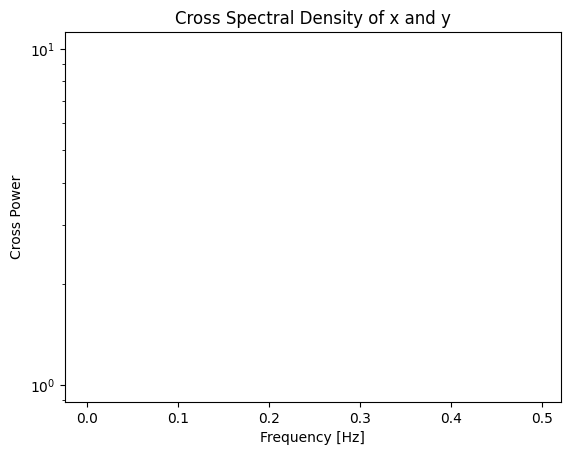

In [12]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
fs = 1 # Sampling frequency
x = hbo_data[0,10,:]
y = hbo_data[0,30,:]

f, Pxy = signal.csd(x, y, fs)
print(f'Pxy.mean() -> {Pxy.mean()}')
plt.figure()
plt.semilogy(f, np.abs(Pxy))
plt.title('Cross Spectral Density of x and y')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Cross Power')
plt.show()


In [59]:
allf, allPxy = signal.csd(hbo_data, hbr_data, fs, nperseg=1024)


/Users/shanxiafeng/miniconda3/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


Pearson;s correlation coefficent: 0.9758274665688643


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


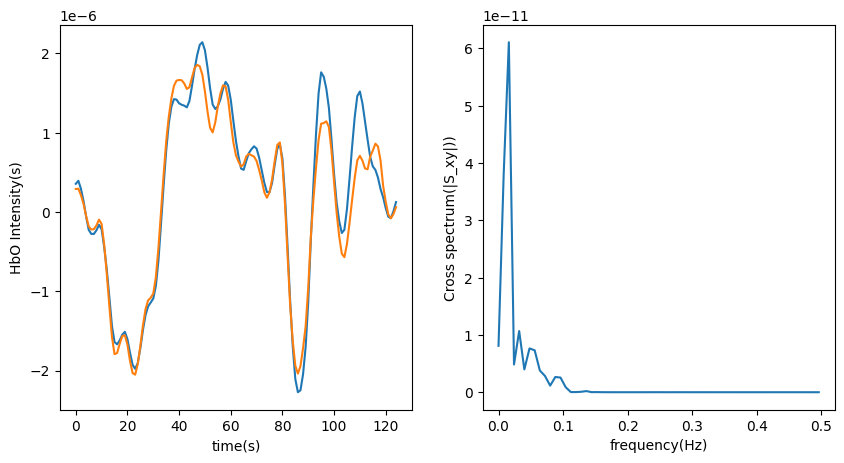

<Figure size 640x480 with 0 Axes>

In [53]:
import numpy as np
from scipy import signal
from scipy import stats

# plt.imshow()
fs = 1 
x = hbo_data[0][4]
y = hbo_data[0][5]
f, Pxy = signal.csd(x, y, fs)
Sxy = Pxy.mean()

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(x, label='x')
axs[0].plot(y, label='y')
axs[0].set_xlabel('time(s)')
axs[0].set_ylabel('HbO Intensity(s)')

axs[1].plot(f, np.abs(Pxy))
axs[1].set_xlabel('frequency(Hz)')
axs[1].set_ylabel('Cross spectrum(|S_xy|))')

plt.figure()
def compute_correlation(x, y):
    corr, _ = stats.pearsonr(x, y)
    return corr

r = compute_correlation(x,y)
print(f'Pearson;s correlation coefficent: {r}')


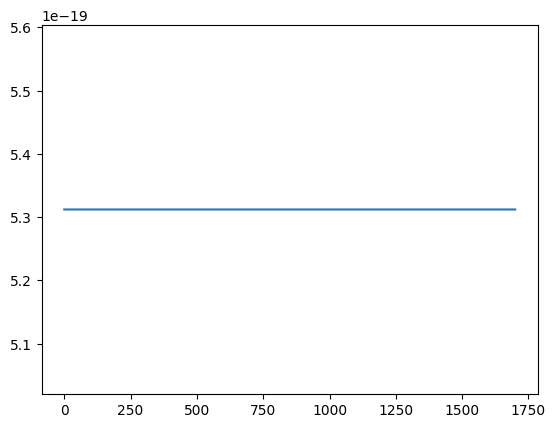

In [21]:
hbo_data = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/raw_cor_ch_data.npy')
hbo_data = np.transpose(hbo_data, (0,2,1))
plt.plot(hbo_data[0,0])

In [13]:
import numpy as np
from joblib import Parallel, delayed

# hbo_data = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/raw_cor_ch_data.npy')
# hbo_data = np.transpose(hbo_data, (0,2,1))

# hbr_data = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-HC-MDD/raw_cor_ch_data.npy')
# hbr_data = np.transpose(hbr_data, (0,2,1))

# 假设 hbo_data 和 hbr_data 是 numpy 数组，形状为 (100, 52, 125)
fs = 1  # 设置您的采样频率
# 定义一个函数来计算两个信号之间的 CSD

from scipy import signal
def compute_csd(x, y, fs):
    f, Pxy = signal.csd(x, y, fs)
    return Pxy.mean()


# 对于每个主题并行计算 CSD
hbo_coh = Parallel(n_jobs=-1)(
    delayed(compute_csd)(hbo_data[i, j], hbo_data[i, k], fs)
    for i in range(hbo_data.shape[0])
    for j in range(hbo_data.shape[1])
    for k in range(hbo_data.shape[1])
)


hbr_coh = Parallel(n_jobs=-1)(
    delayed(compute_csd)(hbr_data[i, j], hbr_data[i, k], fs)
    for i in range(hbr_data.shape[0])
    for j in range(hbr_data.shape[1])
    for k in range(hbr_data.shape[1])
)

"""With out using parallel computing
It consumes 2xtime to code.

"""
# # Output array to store the mean CSD for each subject and channel pair.
# ordinary_output = np.zeros((hbo_data.shape[0], 52, 52))

# for i, (hbo_subject_data, hbr_subject_data) in enumerate(zip(hbo_data, hbr_data)):
#     for j in range(52):
#         for k in range(52):
#             f, Pxy = signal.csd(hbo_subject_data[j], hbr_subject_data[k], fs, nperseg=1024)
#             ordinary_output[i, j, k] = Pxy.mean()

spatial_hbo_coh_output = np.array(hbo_coh).reshape(hbo_data.shape[0],hbo_data.shape[1],hbo_data.shape[1])
spatial_hbr_coh_output = np.array(hbr_coh).reshape(hbr_data.shape[0],hbr_data.shape[1],hbr_data.shape[1])

/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/shanxiafeng/miniconda3/lib/py

In [14]:
from scipy import stats

# Define a function to compute the Pearson's correlation coefficient
def compute_correlation(x, y):
    corr, _ = stats.pearsonr(x, y)
    return corr


# Compute correlation for hbo data
hbo_cor = Parallel(n_jobs=-1)(
    delayed(compute_correlation)(hbo_data[i, j], hbo_data[i, k])
    for i in range(hbo_data.shape[0])
    for j in range(52)
    for k in range(52)
)

# Compute correlation for hbr data
hbr_cor = Parallel(n_jobs=-1)(
    delayed(compute_correlation)(hbr_data[i, j], hbr_data[i, k])
    for i in range(hbr_data.shape[0])
    for j in range(52)
    for k in range(52)
)


spatial_hbo_cor_output = np.array(hbo_cor).reshape(hbo_data.shape[0],hbo_data.shape[1],hbo_data.shape[1])
spatial_hbr_cor_output = np.array(hbr_cor).reshape(hbo_data.shape[0],hbo_data.shape[1],hbo_data.shape[1])


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/stats/_s

In [15]:
def normalize(data):
    # Iterate over each subject
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        # Calculate the mean and standard deviation for the current subject
        mean = np.mean(data[i])
        std = np.std(data[i])

        # Perform z-normalization for the current subject
        normalized_data[i] = (data[i] - mean) / std
    return normalized_data
def clear_Nan(A):
    xA = A 
    xA[np.isinf(xA)] = np.nan
    no_nan_A =  np.nan_to_num(xA, copy=False)
    return no_nan_A

nor_spatial_hbo_coh_output = np.abs(normalize(clear_Nan(spatial_hbo_coh_output)))
nor_spatial_hbo_cor_output = np.abs(normalize(clear_Nan(spatial_hbo_cor_output)))
nor_spatial_hbr_coh_output = np.abs(normalize(clear_Nan(spatial_hbr_coh_output)))
nor_spatial_hbr_cor_output = np.abs(normalize(clear_Nan(spatial_hbr_cor_output)))

In [ ]:
def clear_Nan(data):
    xA = data
    xA[np.isinf(xA)] = np.nan
    no_nan_A =  np.nan_to_num(xA, copy=False)
    return no_nan_A

for i in range(10):
    plt.figure()
    connectivity = nor_spatial_hbo_cor_output[i]
    plt.imshow(connectivity)
    plt.colorbar()

In [16]:
A = np.concatenate((nor_spatial_hbo_coh_output[...,np.newaxis],
                    nor_spatial_hbo_cor_output[...,np.newaxis],
                    nor_spatial_hbr_coh_output[...,np.newaxis],
                    nor_spatial_hbr_cor_output[...,np.newaxis]),
                   axis=3)

# A = np.concatenate((spatial_hbo_coh_output[...,np.newaxis],
#                     spatial_hbo_cor_output[...,np.newaxis],
#                     spatial_hbr_coh_output[...,np.newaxis],
#                     spatial_hbr_cor_output[...,np.newaxis]),
#                    axis=3)

np.save(feature_save_path + 'A',A)
# np.save('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/reference_network/MGN-Net/simulated_dataset/data_yu.npy', A)

In [24]:
print(A.shape)

(458, 52, 52, 4)


In [17]:
print(A[0,0,0])
xA = np.abs(A) 
xA[np.isinf(xA)] = np.nan
no_nan_A =  np.nan_to_num(xA, copy=False)
print(xA[0,0,0])

[7.36090523e-69+3.67785814e-118j            nan+0.00000000e+000j
 1.84022631e-69+9.19464534e-119j            nan+0.00000000e+000j]
[7.36090523e-69 0.00000000e+00 1.84022631e-69 0.00000000e+00]


(458, 52, 1701)


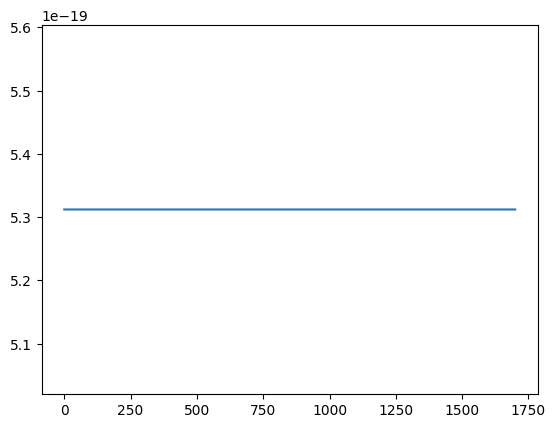

In [19]:
print(hbo_data.shape)
for ch in range(1):
    plt.plot(hbo_data[0,ch,:])

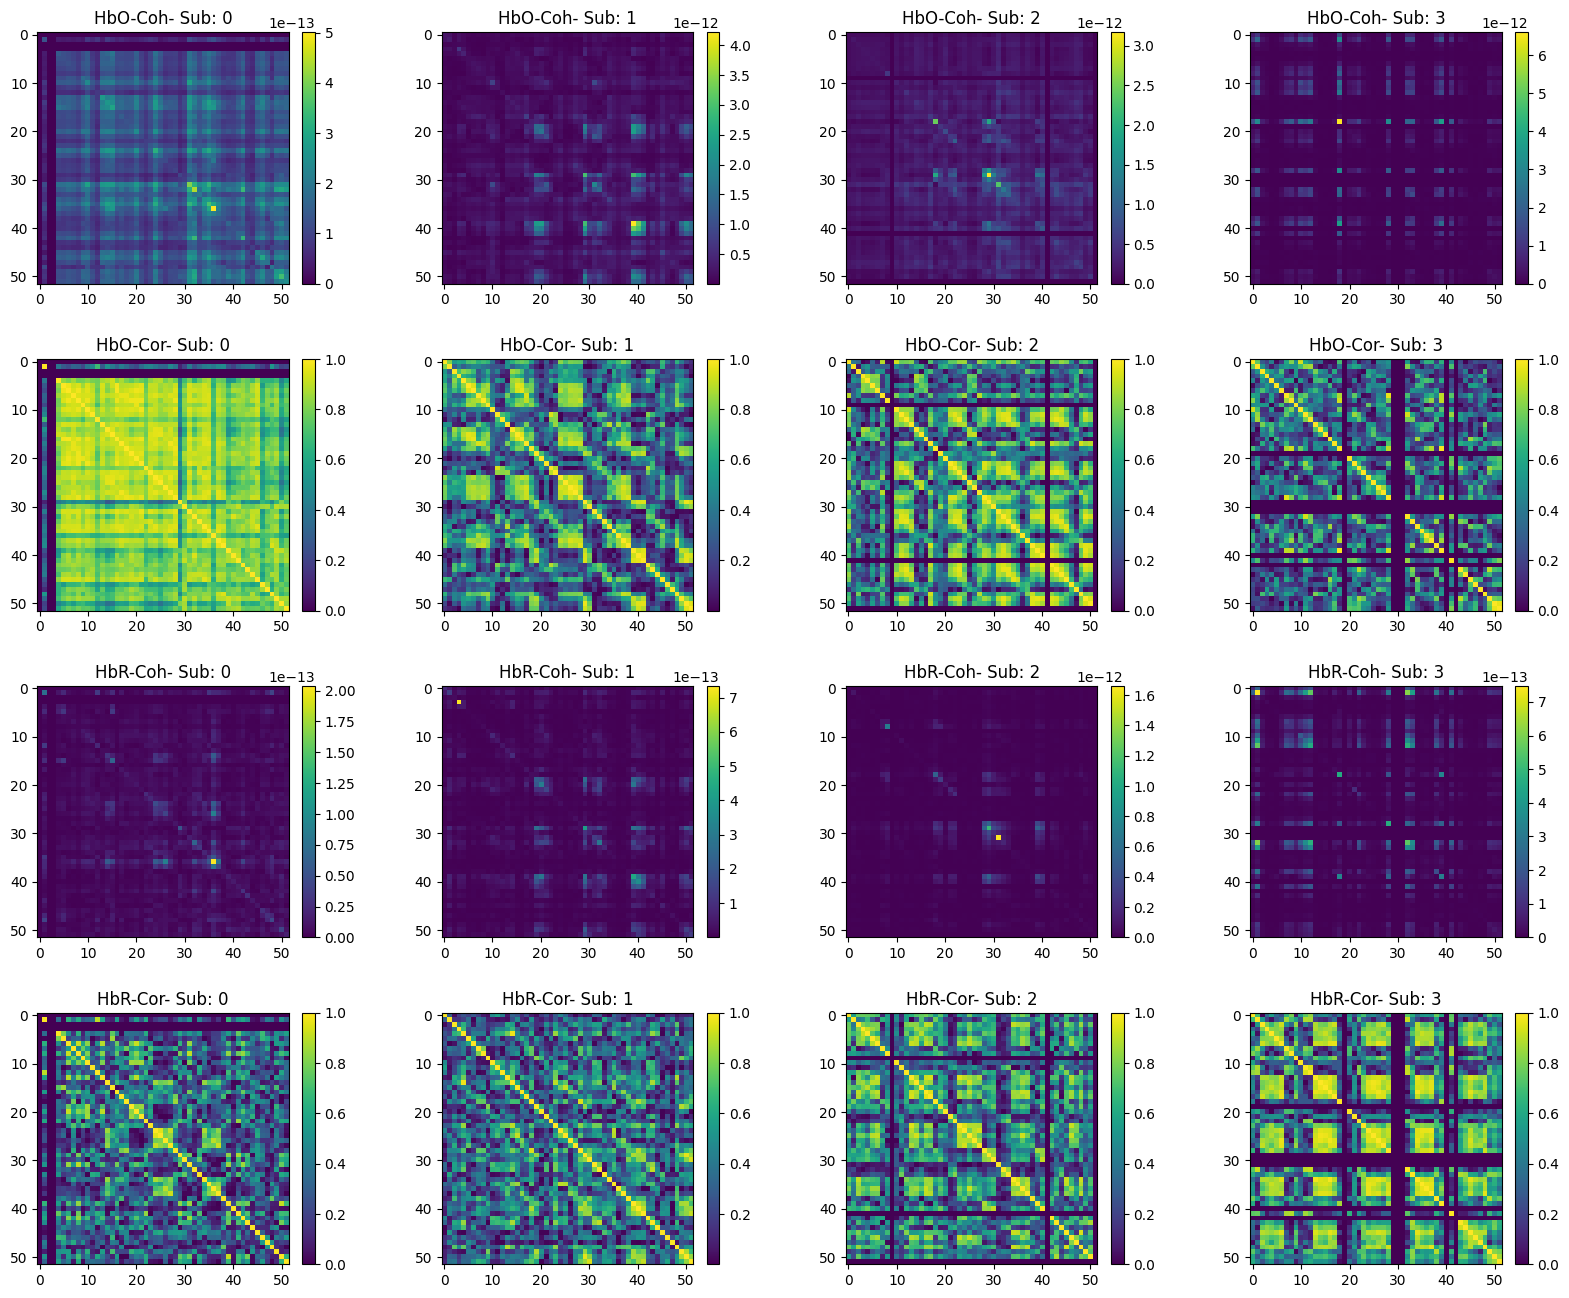

<Figure size 640x480 with 0 Axes>

In [18]:

import matplotlib.pyplot as plt

def compute_connectivity(index):
    connectivity = A[...,index]
    # Replace NaN values with 0
    connectivity = np.nan_to_num(connectivity)

    # Take the absolute values
    connectivity = np.abs(connectivity)

    # Normalize to [0, 1]
    connectivity_min = np.min(connectivity)
    connectivity_max = np.max(connectivity)
    connectivity = (connectivity - connectivity_min) / (connectivity_max - connectivity_min)
    return connectivity

# plt.figure()
fig, axs = plt.subplots(4, 4, figsize=(20,16), gridspec_kw={'hspace': 0.3})
con_title = ['HbO-Coh', 'HbO-Cor', 'HbR-Coh', 'HbR-Cor', 'HbO+HbR-Cor']
plt.figure()
for connectivity_index in range(4):
    con = xA[..., connectivity_index]
    for subject_index in range(4):
        im=axs[connectivity_index, subject_index].imshow(con[subject_index])
        axs[connectivity_index, subject_index].set_title(f'{con_title[connectivity_index]}- Sub: {subject_index}')
        fig.colorbar(im, ax=axs[connectivity_index, subject_index], fraction=0.046, pad=0.04)
    # plt.bar()

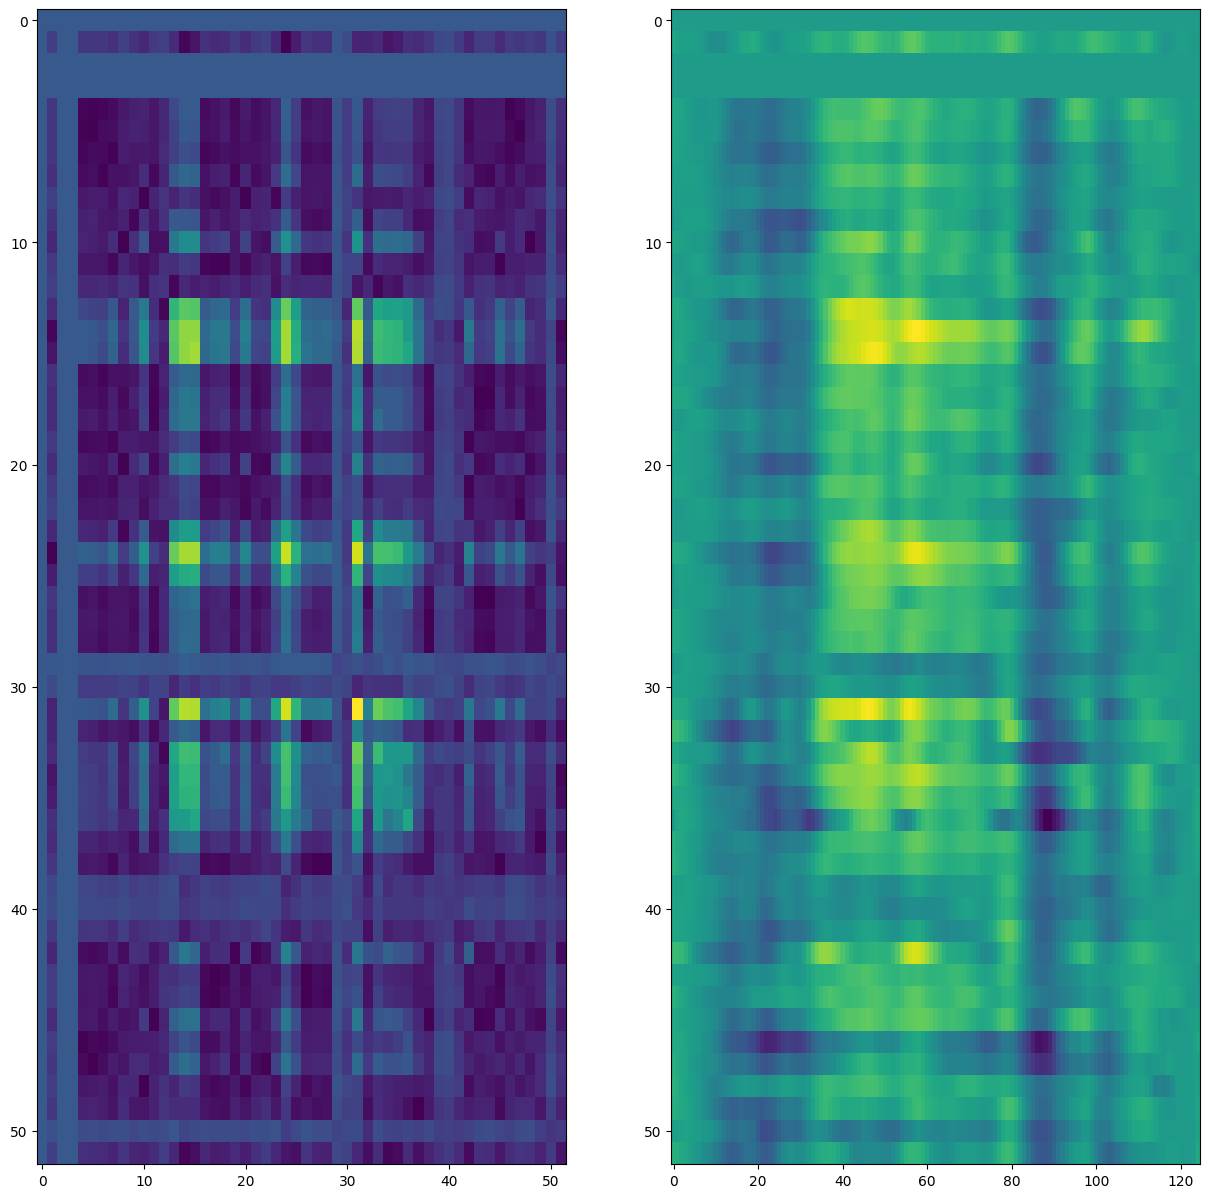

In [30]:
# Verify the channels 1 - 5 in sub: 0 to see if they are set to 0 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1, 2, figsize=(15,15))
A = np.load('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/reference_network/MGN-Net/simulated_dataset/data_yu.npy')
hbo_cor = A[...,0]
axs[0].imshow(hbo_cor[0], aspect='auto')
axs[1].imshow(hbo_data[0], aspect='auto')

y_lim = axs[0].get_ylim()
axs[1].set_ylim(y_lim)
plt.show()

In [20]:
A[...,0].shape

(458, 52, 52)

In [19]:
np.save('/Users/shanxiafeng/Documents/Code/python/fnirs_DL/reference_network/MGN-Net/simulated_dataset/data_yu.npy',A)